In [ ]:
#
# Instala techminer desde el repo de GitHub
#
!pip install -U git+https://github.com/jdvelasq/techminer 

In [1]:
import techminer

In [2]:
# Carga los datos bibliográficos
rdf = techminer.load_dynacol_citedby().data
rdf.index = range(len(rdf))
rdf = techminer.nan2none(rdf)
rdf.columns.tolist()

['Abstract',
 'Affiliations',
 'Author Keywords',
 'Author(s) ID',
 'Authors',
 'Authors with affiliations',
 'Cited by',
 'DOI',
 'Document Type',
 'EID',
 'Index Keywords',
 'Issue',
 'Page end',
 'Page start',
 'Source title',
 'Title',
 'Volume',
 'Year']

In [3]:
# numero total de documentos
len(rdf) 

3411

In [4]:
# Número de registros sin palabras clave
(
    len(rdf[rdf["Author Keywords"].map(lambda x: x is None)]),
    len(rdf[rdf["Index Keywords"].map(lambda x: x is None)]),
)

(364, 1451)

In [ ]:
rdf["Keywords"] = techminer.merge_fields(
    rdf["Author Keywords"], rdf["Index Keywords"], sepA=";", sepB=";", new_sep=";"
)

len(rdf[rdf["Keywords"].map(lambda x: x is None)])

In [5]:
rdf["Keywords"] = rdf["Author Keywords"]

In [6]:
# Número de abstracts vacios
len(rdf[rdf["Abstract"].map(lambda x: x is None)])

0

In [7]:
# Número de artículos sin título
len(rdf[rdf["Title"].map(lambda x: x is None)])

0

In [8]:
# Remove el copyright del abstract
import numpy as np

In [9]:
# Se remueve el copyright de los abstracts
rdf["Abstract"] = rdf["Abstract"].map(
    lambda x: x[0 : x.find("\u00a9")]
    if isinstance(x, str) and x.find("\u00a9") != -1
    else x
)

# Crea la unión del título y del abstract
title_abstract = techminer.merge_fields(rdf["Title"], rdf["Abstract"], new_sep=" ")

# Crea un objeto para manejo de palabras clave
kyw = techminer.Keywords()

# Adiciona las palabras clave de los artículos
kyw.add_keywords(rdf["Keywords"], sep=";")


In [10]:
keywords_title_abstract = title_abstract[rdf['Keywords'].map(lambda u: u is None)].map(
    lambda x: kyw.extract_from_text(x, sep=";")
)

In [11]:
for idx in keywords_title_abstract.index.tolist():
    rdf.loc[idx, 'Keywords'] = keywords_title_abstract[idx]

len(rdf[rdf["Keywords"].map(lambda x: x is None)])

0

In [12]:
# Borrado de abstracts de procceedings y workshops
conf = techminer.Keywords()
conf.add_keywords(["Conference", "Proceeding", "Workshop", "Congress"])
rdf["CONF"] = rdf["Title"].map(lambda x: True if x in conf else False)

for title in rdf[rdf["CONF"]]["Title"]:
    print(title)

# ninguno

In [13]:
# Documentos con el mismo título
print("Num. records before = ", len(rdf))
rdf = techminer.remove_duplicate_records(rdf, "Title", match_type="fingerprint")
print("Num. records after = ", len(rdf))

Num. records before =  3411
Num. records after =  3403


In [14]:
# Limpieza de palabras clave
rdf['Keywords'] = rdf['Keywords'].map(lambda x: x.lower())
th = techminer.text_clustering(rdf['Keywords'], sep=';', transformer=lambda x: x.lower())

In [15]:
keywords = rdf['Keywords']
keywords = keywords.map(lambda x: x.split(';'))
keywords = keywords.map(lambda x: [u.strip() for u in x])
keywords_dict = {}
for key in th._thesaurus.keys():
    values = th._thesaurus[key]
    for value in values:
        keywords_dict[value.lower()] = key
keywords = keywords.map(lambda x: [keywords_dict[u] if u in keywords_dict.keys() else u  for u in x])    
keywords = keywords.map(lambda x: ';'.join(x))
rdf['Keywords'] = keywords
rdf['Keywords'].head(15)

0     compressive sampling;dsp;gc5016;random filters...
1     2;eis;steel;thi;xrd;action;addition;analysis;c...
2     colombian crude oils;oil evaporation;oil spill...
3     attractiveness;freight trip attraction;retail;...
4     competency;natural language processing;semanti...
5     case;case study;co;kaizen;lean;thinking;ani;ap...
6     concentration;nonimaging optical system;solar ...
7     apple;cold store;computational fluid dynamics ...
8     animal welfare;cold stress;model validation;no...
9     concrete;granite powder;marble powder;producti...
10    air pollution;environment;epidemiology;lung di...
11    communities on the web;web media;web-based edu...
12    climate;climate change;human;island;recharge;s...
13    environmental impact;geostatistics;kriging;min...
14    graphene template;in-plane heterostructures;li...
Name: Keywords, dtype: object

In [32]:
keywords = rdf['Keywords']
keywords = keywords.map(lambda x: x.split(';'))
keywords = keywords.map(lambda x: [u for u in x if len(u) > 3])
keywords = keywords.map(lambda x: ';'.join(x))
rdf['Keywords'] = keywords

In [ ]:
# Aplica el diccionario a las palabras clave
#rdf["Keywords"] = rdf["Keywords"].map(lambda x: th.apply(x, sep=";"))

In [33]:
# Elimina espacios en blanco
rdf["Keywords"] = rdf["Keywords"].map(
    lambda x: ";".join(set([w.strip() for w in x.split(";")]))
)

In [34]:
# Cambia cadenas vacias por None
rdf["Keywords"] = rdf["Keywords"].map(
    lambda x: x if x != "" else None
)

In [35]:
# Numeración de registros para referencias
rdf = techminer.RecordsDataFrame(rdf).generate_ID()

In [36]:
# Numero de registros
len(rdf)

3403

In [37]:
rdf.documents_by_terms("Document Type")

,Document Type,Num Documents,ID
0,Article,2601,"[[*2*], [*3*], [*4*], [*7*], [*9*], [*10*], [*..."
1,Conference Paper,559,"[[*0*], [*1*], [*6*], [*8*], [*13*], [*15*], [..."
2,Review,150,"[[*47*], [*81*], [*123*], [*158*], [*160*], [*..."
3,Book Chapter,74,"[[*5*], [*53*], [*54*], [*231*], [*269*], [*29..."
4,Editorial,6,"[[*203*], [*351*], [*615*], [*2856*], [*2958*]..."
5,Note,3,"[[*1309*], [*1530*], [*2288*]]"
6,Article in Press,2,"[[*2023*], [*2547*]]"
7,Book,2,"[[*1831*], [*2841*]]"
8,Data Paper,2,"[[*1468*], [*1528*]]"
9,Letter,2,"[[*427*], [*1612*]]"


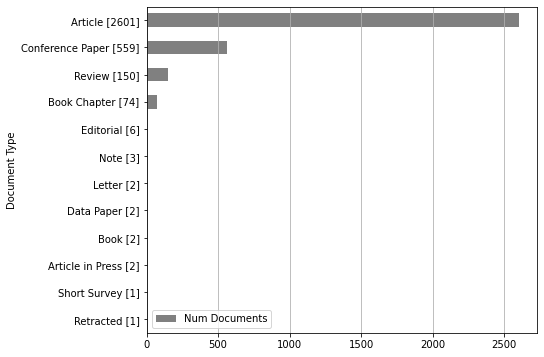

In [38]:
rdf.documents_by_terms("Document Type").barhplot(figsize=(7, 6))

In [39]:
rdf.documents_by_terms("Source title", minmax=(23, 10000))

,Source title,Num Documents,ID
0,DYNA (Colombia),568,"[[*23*], [*24*], [*26*], [*27*], [*28*], [*29*..."
1,Informacion Tecnologica,56,"[[*49*], [*50*], [*51*], [*52*], [*119*], [*12..."
2,Journal of Physics: Conference Series,44,"[[*1*], [*511*], [*930*], [*1110*], [*1335*], ..."
3,Advances in Intelligent Systems and Computing,36,"[[*15*], [*746*], [*1214*], [*1235*], [*1270*]..."
4,Espacios,34,"[[*1799*], [*1850*], [*1860*], [*1861*], [*189..."
5,Construction and Building Materials,33,"[[*113*], [*147*], [*220*], [*221*], [*265*], ..."
6,Ingenieria e Investigacion,28,"[[*214*], [*473*], [*474*], [*924*], [*929*], ..."
7,Revista Facultad de Ingenieria,27,"[[*126*], [*156*], [*157*], [*365*], [*456*], ..."
8,Sustainability (Switzerland),26,"[[*194*], [*223*], [*1119*], [*1120*], [*1244*..."
9,Energies,26,"[[*16*], [*180*], [*732*], [*1111*], [*1124*],..."


In [54]:
len(rdf.documents_by_terms("Source title", minmax=(0, 10000)))

1455

In [42]:
rdf.documents_by_terms("Authors", sep=",", top_n=30)

,Authors,Num Documents,ID
0,Calvo-Rolle J.L.,19,"[[*15*], [*746*], [*1151*], [*1165*], [*1166*]..."
1,Manzano-Agugliaro F.,17,"[[*42*], [*493*], [*531*], [*573*], [*640*], [..."
2,García-Alcaraz J.L.,16,"[[*83*], [*85*], [*385*], [*405*], [*450*], [*..."
3,Cortés F.B.,15,"[[*201*], [*254*], [*561*], [*775*], [*1063*],..."
4,Franco C.A.,13,"[[*201*], [*254*], [*775*], [*1063*], [*1107*]..."
5,Gonzalez-Feliu J.,13,"[[*3*], [*116*], [*405*], [*701*], [*1179*], [..."
6,Wang Y.,13,"[[*697*], [*844*], [*1638*], [*1738*], [*1869*..."
7,Rojas-Sola J.I.,13,"[[*109*], [*150*], [*174*], [*228*], [*355*], ..."
8,Escobar J.W.,13,"[[*378*], [*1189*], [*1203*], [*1808*], [*2181..."
9,Arango-Serna M.D.,12,"[[*28*], [*393*], [*447*], [*594*], [*1315*], ..."


In [47]:
dyna = techminer.load_dynacol().data
dyna = dyna.generate_ID()
authors_dyna = dyna.documents_by_terms("Authors", sep=",")['Authors']
authors_dyna.head()

0            Correa R.
1     Adarme-Jaimes W.
2       Velásquez J.D.
3    Arango-Serna M.D.
4      Rojas-Sola J.I.
Name: Authors, dtype: object

In [48]:
authors_cites = rdf.documents_by_terms("Authors", sep=",")['Authors']
authors_cites.head()

0        Calvo-Rolle J.L.
1    Manzano-Agugliaro F.
2     García-Alcaraz J.L.
3             Cortés F.B.
4             Franco C.A.
Name: Authors, dtype: object

In [52]:
len(authors_cites)

10217

In [51]:
len(list(set(authors_dyna.tolist()) & set(authors_cites.tolist())))

1972

In [65]:
authors = rdf['Authors']
authors = authors.map(lambda x: x.split(','))
authors = authors.map(lambda x: [u in authors_dyna.tolist() for u in x])
authors = authors.map(lambda x: not any(x))
len(authors[authors])

2450

In [66]:
rdf.documents_by_terms("Keywords", sep=";", top_n=20)

,Keywords,Num Documents,ID
0,model,153,"[[*12*], [*45*], [*111*], [*112*], [*138*], [*..."
1,method,129,"[[*1*], [*45*], [*189*], [*231*], [*237*], [*2..."
2,work,125,"[[*1*], [*45*], [*189*], [*237*], [*270*], [*2..."
3,process,111,"[[*5*], [*105*], [*189*], [*249*], [*267*], [*..."
4,stem,104,"[[*111*], [*112*], [*193*], [*234*], [*249*], ..."
5,paper,96,"[[*5*], [*45*], [*81*], [*112*], [*193*], [*24..."
6,structure,88,"[[*60*], [*234*], [*237*], [*323*], [*371*], [..."
7,tial,86,"[[*12*], [*46*], [*249*], [*255*], [*270*], [*..."
8,design,86,"[[*46*], [*189*], [*297*], [*312*], [*446*], [..."
9,analysis,81,"[[*1*], [*45*], [*112*], [*228*], [*249*], [*4..."


In [41]:
rdf["Country"] = rdf["Affiliations"].map(lambda x: techminer.extract_country(x, sep=";"))
rdf.documents_by_terms("Country", sep=";").head(15)

,Country,Num Documents,ID
0,Colombia,2153,"[[*1*], [*2*], [*2*], [*10*], [*11*], [*11*], ..."
1,Spain,805,"[[*3*], [*15*], [*15*], [*15*], [*16*], [*16*]..."
2,Mexico,552,"[[*18*], [*18*], [*18*], [*23*], [*37*], [*37*..."
3,Brazil,540,"[[*8*], [*27*], [*62*], [*68*], [*88*], [*94*]..."
4,China,468,"[[*0*], [*0*], [*14*], [*14*], [*14*], [*14*],..."
5,United States,297,"[[*14*], [*17*], [*19*], [*19*], [*56*], [*60*..."
6,Chile,197,"[[*44*], [*69*], [*69*], [*69*], [*72*], [*98*..."
7,India,195,"[[*9*], [*9*], [*19*], [*164*], [*243*], [*247..."
8,Malaysia,142,"[[*160*], [*358*], [*445*], [*472*], [*472*], ..."
9,France,138,"[[*3*], [*116*], [*125*], [*125*], [*166*], [*..."


In [67]:
len(rdf.documents_by_terms("Country", sep=";"))

96

In [ ]:
rdf.documents_by_terms("Country", sep=";").worldmap()

In [ ]:
rdf.terms_by_year(column="Authors", sep=",", top_n=20).heatmap(figsize=(11, 7))

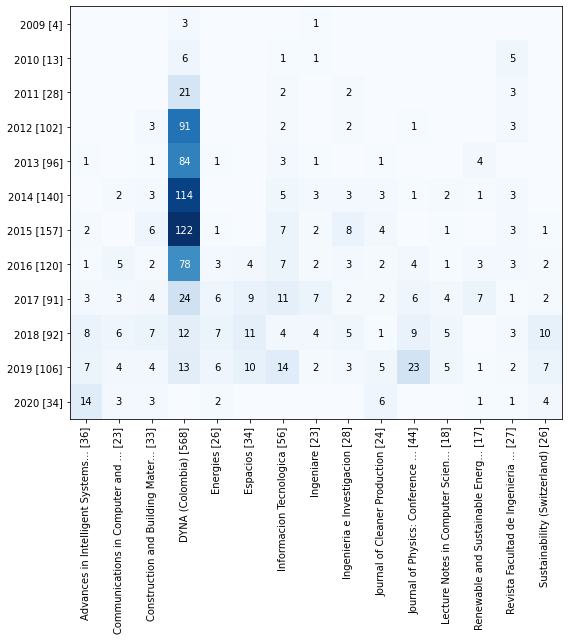

In [69]:
rdf.terms_by_year(column="Source title", sep=None, top_n=15).heatmap(figsize=(8, 9))

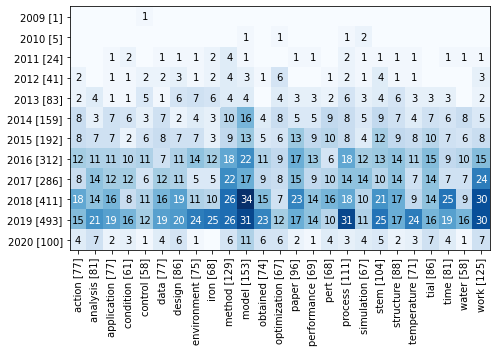

In [75]:
rdf.terms_by_year(column="Keywords", sep=";", top_n=25).heatmap(
    figsize=(7, 5)
)

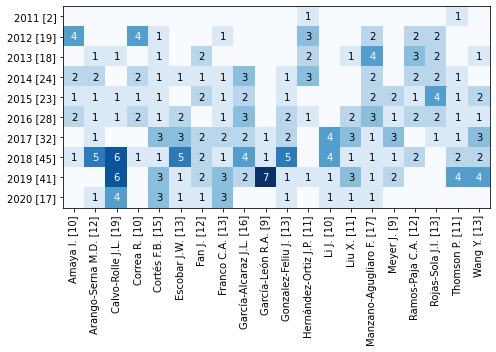

In [78]:
rdf.terms_by_year(column="Authors", sep=",", top_n=20).heatmap(figsize=(7, 5))

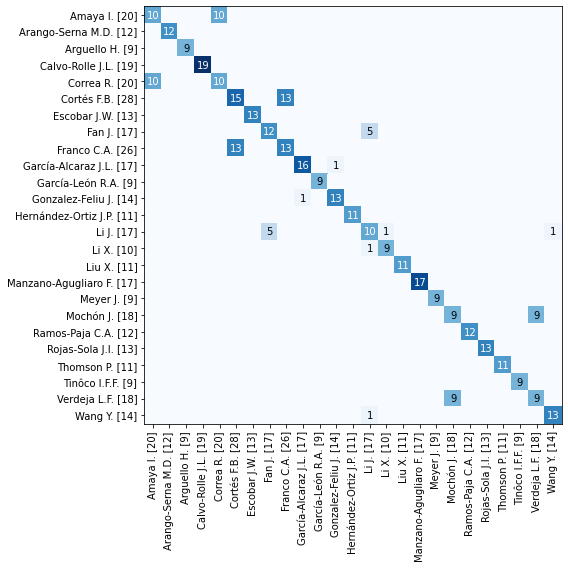

In [83]:
rdf.ocurrence(column="Authors", sep=",", top_n=25 ).heatmap(figsize=(8, 8), ascending_r=True, ascending_c=True)

In [84]:
rdf.ocurrence(column="Authors", sep=",", top_n=25 )

,Authors (row),Authors (col),Num Documents,ID
0,Amaya I. [20],Amaya I. [20],10,"[[*382*], [*442*], [*764*], [*765*], [*773*], ..."
1,Amaya I. [20],Correa R. [20],10,"[[*382*], [*442*], [*764*], [*765*], [*773*], ..."
2,Arango-Serna M.D. [12],Arango-Serna M.D. [12],12,"[[*28*], [*393*], [*447*], [*594*], [*1315*], ..."
3,Arguello H. [9],Arguello H. [9],9,"[[*1355*], [*1357*], [*2241*], [*2403*], [*240..."
4,Calvo-Rolle J.L. [19],Calvo-Rolle J.L. [19],19,"[[*15*], [*746*], [*1151*], [*1165*], [*1166*]..."
5,Correa R. [20],Amaya I. [20],10,"[[*382*], [*442*], [*764*], [*765*], [*773*], ..."
6,Correa R. [20],Correa R. [20],10,"[[*382*], [*442*], [*764*], [*765*], [*773*], ..."
7,Cortés F.B. [28],Cortés F.B. [28],15,"[[*201*], [*254*], [*561*], [*775*], [*1063*],..."
8,Cortés F.B. [28],Franco C.A. [26],13,"[[*201*], [*254*], [*775*], [*1063*], [*1107*]..."
9,Escobar J.W. [13],Escobar J.W. [13],13,"[[*378*], [*1189*], [*1203*], [*1808*], [*2181..."


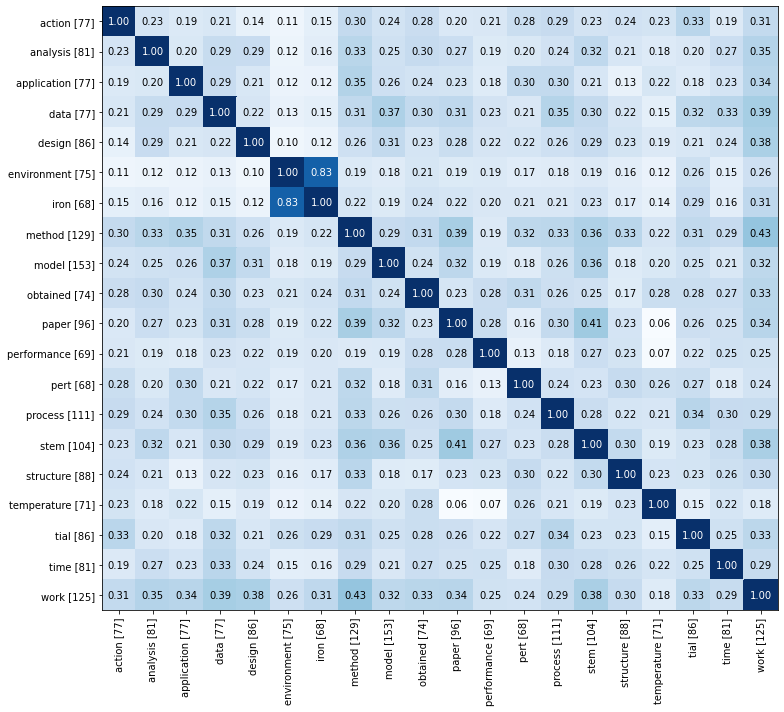

In [86]:
rdf.auto_corr(column="Keywords", sep=";", top_n=20).heatmap(figsize=(11, 10), ascending_r=True, ascending_c=True)

In [ ]:
rdf.co_ocurrence(
    column_r="Authors", column_c="Keywords", sep_r=",", sep_c=";", top_n=20
).heatmap(figsize=(9, 6))

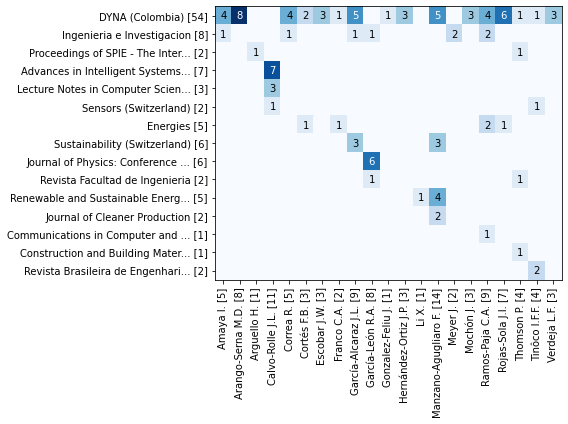

In [91]:
rdf.co_ocurrence(
    column_r="Authors", column_c="Source title", sep_r=",", sep_c=None, top_n=25
).heatmap(figsize=(8, 6))

In [ ]:
rdf.co_ocurrence(
    column_r="Authors", column_c="Keywords", sep_r=",", sep_c=";", top_n=20
).tomatrix()

In [ ]:
rdf.terms_by_terms_by_year(
    column_r='Authors',
    column_c='Source title',
    sep_r=',',
    sep_c=None)

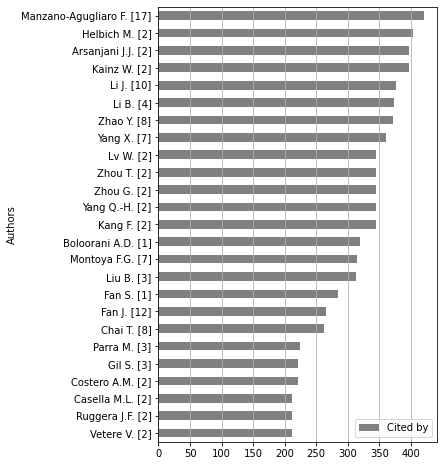

In [94]:
rdf.citations_by_terms('Authors', sep=',', top_n=25).barhplot(figsize=(5,8))

# Manzano
# Li J.

In [105]:
x = rdf.citations_by_terms('Authors', sep=',', top_n=25)
x = x['Authors']
x = x.map(lambda u: u[0:u.find('[')].strip())
x

0     Manzano-Agugliaro F.
1               Helbich M.
2           Arsanjani J.J.
3                 Kainz W.
4                    Li J.
5                    Li B.
6                  Zhao Y.
7                  Yang X.
8                  Zhou T.
9                  Zhou G.
10              Yang Q.-H.
11                   Lv W.
12                 Kang F.
13          Boloorani A.D.
14            Montoya F.G.
15                  Liu B.
16                  Fan S.
17                  Fan J.
18                 Chai T.
19                Parra M.
20                  Gil S.
21            Costero A.M.
22            Ruggera J.F.
23            Casella M.L.
24               Vetere V.
Name: Authors, dtype: object

In [109]:
y = [m in authors_dyna.tolist() for m in x.tolist()]
sum(y)

3

In [110]:
x[y]

0     Manzano-Agugliaro F.
6                  Zhao Y.
14            Montoya F.G.
Name: Authors, dtype: object

In [ ]:
rdf.citations_by_terms('Keywords', sep=';', top_n=20).barhplot(figsize=(6,8))

In [ ]:
rdf.citations_by_terms('Source title', sep=None, top_n=30).barhplot(figsize=(6,10))

In [ ]:
rdf.auto_corr(column="Authors", sep=",", top_n=20).heatmap(figsize=(10, 10))

In [ ]:
rdf.auto_corr(column="Authors", sep=",", top_n=20).chord_diagram(figsize=(10, 10))

In [ ]:
rdf.auto_corr(column="Keywords", sep=";", top_n=10).heatmap(figsize=(8, 8))

In [ ]:
rdf.factor_analysis(column="Authors", sep=",", n_components=5, top_n=20).chord_diagram()